# Object Measurement Using Refrence Marker

Please refer to `scale_calculation/measuring_scale_cv.ipnb` for extensive indepth documentation stating how did we get the value of scale.

As we have already calculated the scale(cm per pixel), we're simply going to locate our object of interest(the blue thing) and do our thing!

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.spatial import distance as dist

In [13]:
scale =0.0120194767568

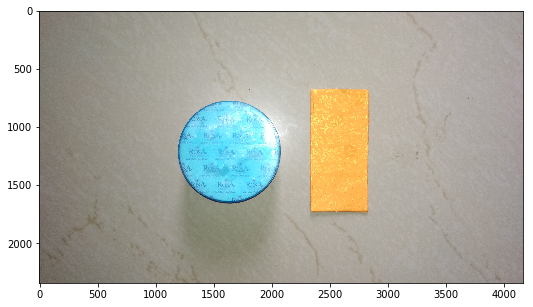

In [14]:
image = cv2.imread("cld_1.jpg")
image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,5))
y = fig.add_subplot(1,1,1)
y.imshow(image_)

The blue cap is the object whose dimension we are interested in. The orange strip is our marker of known length and width.

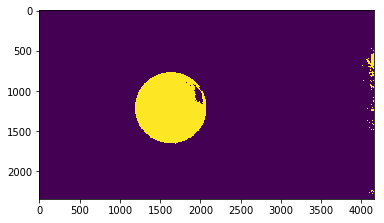

In [15]:
# Lets extract the object 
mark_hsv_l = [65,15,80]
mark_hsv_h = [255,255,255]

hsv_marker = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

mark_hsv_l = np.array(mark_hsv_l,np.uint8)
mark_hsv_h = np.array(mark_hsv_h,np.uint8)

frame_threshed = cv2.inRange(hsv_marker, mark_hsv_l, mark_hsv_h)

fig=plt.figure()
y=fig.add_subplot(1,1,1)
y.imshow(frame_threshed)

As I have already discussed that there are multiple ways of locating an object.
- Using ML
- Using CV

I have discussed how to select the techniques on the scale measurement but when you are sure that the elementary properties like shape, size, light intensity, exposure, HTT etc will remain consistent throughout all the images that woould be input to your algorithm, you can count on CV else if you want flexibility then Deep Learing and other ML tech are useful.

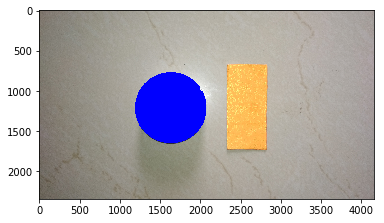

In [16]:
_,contours,hierarchy=cv2.findContours(frame_threshed,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# Max area cnt in the above image will be of the marker for sure
cnt = max(contours, key=cv2.contourArea)
im = cv2.drawContours(image_, [cnt],-1, (0,0,255),-1)

fig=plt.figure()
y=fig.add_subplot(1,1,1)
y.imshow(im)

Successfully located the object!

In [17]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)

I have fitted the minAreaRect on the contour of the object because the length and width of that rectangle would be the diameter of our object. As there is slight angle of elevation in the original image, we might see differnt values of diameter but if we have done everything right, we shouldn't worry!

In [18]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def order_points(pts):
    pts=np.int0(pts)

    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def midpoint(ptA, ptB):
    '''
    functions takes input two points (x1,y1) and (x2,y2)
    return the midpoint.
    '''
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [19]:
box = order_points(box)

In [20]:
text_color= [255,255,255]
text_width = 2
text_size =6

In [21]:

if len(box) == 4:
    for (x, y) in box:
        image_=image.copy()
        (A, B, C, D) = box
        cv2.line(image_,(A[0],A[1]),(B[0],B[1]),(0,255,0),3)
        cv2.line(image_,(C[0],C[1]),(D[0],D[1]),(0,255,0),3)

        cv2.line(image_,(A[0],A[1]),(D[0],D[1]),(0,255,0),3)
        cv2.line(image_,(B[0],B[1]),(C[0],C[1]),(0,255,0),3)

        (ma, mb) = midpoint(A, B)
        (mc, md) = midpoint(C, D)
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (mA, mD) = midpoint(D,A)
        (mB, mC) = midpoint(B, C)
      
        #measuring the distances 
        
        ab= dist.euclidean((A[0], A[1]), (B[0], B[1])) *scale
        bc= dist.euclidean((C[0], C[1]), (B[0], B[1])) *scale
        cd = dist.euclidean((C[0], C[1]), (D[0],D[1])) *scale
        ad = dist.euclidean((A[0], A[1]), (D[0], D[1])) *scale

        cv2.putText(image_,"{:.2f}cm".format(ab),
            (int(ma), int(mb)), cv2.FONT_HERSHEY_SIMPLEX,
            text_width, text_color, text_size)

        cv2.putText(image_, "{:.2f}cm".format(bc),
            (int(mB),int(mC)), cv2.FONT_HERSHEY_SIMPLEX,
            text_width, text_color, text_size)

        cv2.putText(image_, "{:.2f}cm".format(cd),
            (int(mc), int(md)), cv2.FONT_HERSHEY_SIMPLEX,
            text_width, text_color, text_size)

        cv2.putText(image_, "{:.2f}cm".format(ad),
            (int(mA), int(mD)), cv2.FONT_HERSHEY_SIMPLEX,
            text_width, text_color, text_size)

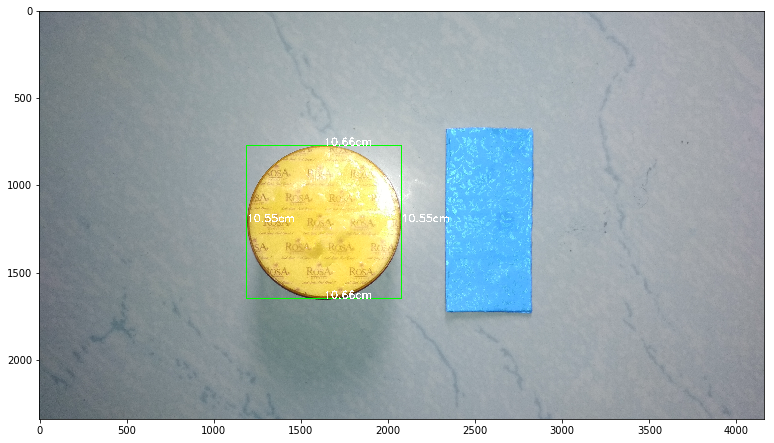

In [22]:
fig = plt.figure(figsize=(12*1.50, 5*1.50))
y = fig.add_subplot(1,1,1)
y.imshow(image_)
plt.show()

In [25]:
abs(10.6-10.66)*100/10.6

0.5660377358490614

As suspected, there's a bit of variance due to the tilt of camera. However the correct value of the diameter of this circular disc is 10.6cm. Thus both the values have variance 0.5 percent!!!